# Import Library and Datasets

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from itertools import permutations
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")



In [27]:
#Read all csv files
cust = pd.read_csv('customer.csv',sep=';')
trans = pd.read_csv('transaction.csv',sep=';')
prod = pd.read_csv('product.csv',sep=';')
store = pd.read_csv('store.csv',sep=';')

In [28]:
trans.sample(3)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1704,TR5564,290,02/05/2022,P10,15000,1,15000,9
2692,TR34405,133,12/07/2022,P5,4200,5,21000,2
607,TR78942,165,13/02/2022,P1,8800,2,17600,14


In [29]:
cust.sample(3)

,CustomerID,Age,Gender,Marital Status,Income
105,106,24,0,Single,"6,79"
245,246,40,1,Single,"21,81"
298,299,37,1,Married,"4,54"


In [30]:
prod.sample(3)

,ProductID,Product Name,Price
6,P7,Coffee Candy,9400
9,P10,Cheese Stick,15000
4,P5,Thai Tea,4200


In [31]:
store.sample(3)

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
10,11,Sinar Harapan,Prestasi,General Trade,"0,533505","101,447403"
13,14,Priangan,Priangan,Modern Trade,"-5,45","105,26667"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"


In [32]:
#Merging all data frame on transaction
df = pd.merge(trans,cust,on='CustomerID')
df = pd.merge(df,prod,on='ProductID',suffixes=('_cust','_prod'))
df = pd.merge(df,store,on='StoreID')
df.sample(3)

,TransactionID,CustomerID,Date,ProductID,Price_cust,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_prod,StoreName,GroupStore,Type,Latitude,Longitude
3711,TR55797,260,12/07/2022,P5,4200,5,21000,8,33,0,Single,"6,65",Thai Tea,4200,Sinar Harapan,Harapan Baru,General Trade,"5,54829","95,323753"
2554,TR71313,370,26/09/2022,P3,7500,2,15000,3,26,1,Single,"1,28",Crackers,7500,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3253,TR47559,307,13/03/2022,P3,7500,2,15000,2,31,0,Married,"5,22",Crackers,7500,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"


In [33]:
#rename columns name to lowercase
col_name = {}
for i in df.columns:
    col_name[i] = i.lower().replace(' ','_')
df = df.rename(columns=col_name)
df.sample(3)

,transactionid,customerid,date,productid,price_cust,qty,totalamount,storeid,age,gender,marital_status,income,product_name,price_prod,storename,groupstore,type,latitude,longitude
3010,TR95371,46,25/08/2022,P5,4200,2,8400,14,36,1,Married,"8,31",Thai Tea,4200,Priangan,Priangan,Modern Trade,"-5,45","105,26667"
522,TR45168,235,30/12/2022,P1,8800,7,61600,13,37,0,Married,"5,35",Choco Bar,8800,Buana,Buana,General Trade,"-1,26916","116,825264"
2669,TR56905,38,02/03/2022,P5,4200,4,16800,3,56,0,Married,"14,32",Thai Tea,4200,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"


# Data cleaning

In [34]:
#Drop irrelevant columns 
df = df.drop(columns=['latitude','longitude'])
df.head(3)

,transactionid,customerid,date,productid,price_cust,qty,totalamount,storeid,age,gender,marital_status,income,product_name,price_prod,storename,groupstore,type
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Crackers,7500,Prestasi Utama,Prestasi,General Trade
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Crackers,7500,Prestasi Utama,Prestasi,General Trade
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Crackers,7500,Prestasi Utama,Prestasi,General Trade


In [35]:
#check dataset shape
df.shape

(5020, 17)

## Data type

In [36]:
#Check datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transactionid   5020 non-null   object
 1   customerid      5020 non-null   int64 
 2   date            5020 non-null   object
 3   productid       5020 non-null   object
 4   price_cust      5020 non-null   int64 
 5   qty             5020 non-null   int64 
 6   totalamount     5020 non-null   int64 
 7   storeid         5020 non-null   int64 
 8   age             5020 non-null   int64 
 9   gender          5020 non-null   int64 
 10  marital_status  4976 non-null   object
 11  income          5020 non-null   object
 12  product_name    5020 non-null   object
 13  price_prod      5020 non-null   int64 
 14  storename       5020 non-null   object
 15  groupstore      5020 non-null   object
 16  type            5020 non-null   object
dtypes: int64(8), object(9)
memory usage: 705.9+ KB


In [37]:
#Convert date and income data type
df['date'] = pd.to_datetime(df['date'])
df['income'] = df['income'].map(lambda x: float(x.replace(',','.')))

df.sample(3)

,transactionid,customerid,date,productid,price_cust,qty,totalamount,storeid,age,gender,marital_status,income,product_name,price_prod,storename,groupstore,type
2460,TR99442,305,2022-07-22,P10,15000,1,15000,9,29,1,Married,4.08,Cheese Stick,15000,Lingga,Lingga,Modern Trade
3191,TR95658,217,2022-11-16,P6,18000,2,36000,14,39,1,Single,6.96,Cashew,18000,Priangan,Priangan,Modern Trade
4483,TR80853,351,2022-01-19,P7,9400,2,18800,11,45,1,Married,18.34,Coffee Candy,9400,Sinar Harapan,Prestasi,General Trade


## Null Value

In [38]:
#Check null
df.isna().sum()

transactionid      0
customerid         0
date               0
productid          0
price_cust         0
qty                0
totalamount        0
storeid            0
age                0
gender             0
marital_status    44
income             0
product_name       0
price_prod         0
storename          0
groupstore         0
type               0
dtype: int64

In [39]:
#Null values are in marital_status columns
#Impute nan values using KNNImputer
#Lets use customer data to support imputer process
df_impute = df[['age','gender','income','marital_status']]
df_impute['marital_status'] = df_impute['marital_status'].map({'Married':1,'Single':0})

imputer = KNNImputer(n_neighbors=2)
df_impute = imputer.fit_transform(df_impute)
df_impute = pd.DataFrame(data=df_impute,columns=['age','gender','income','marital_status'])

print('Null check :',df_impute.isna().sum().sum())
print('')
print('Data size :',df_impute.shape)

Null check : 0

Data size : (5020, 4)


In [40]:
#join the imputate data to dataframe
df['marital_status'] = df_impute['marital_status'].astype('int')

#check null
df.isna().sum()

transactionid     0
customerid        0
date              0
productid         0
price_cust        0
qty               0
totalamount       0
storeid           0
age               0
gender            0
marital_status    0
income            0
product_name      0
price_prod        0
storename         0
groupstore        0
type              0
dtype: int64

# Forecasting Data Preparation

In [163]:
#Forecast data
df_fore = df[['date','qty']]
df_fore= df_fore.groupby('date')[['qty']].sum()
df_fore.head(3)

,qty
date,
2022-01-01,49
2022-01-02,50
2022-01-03,76


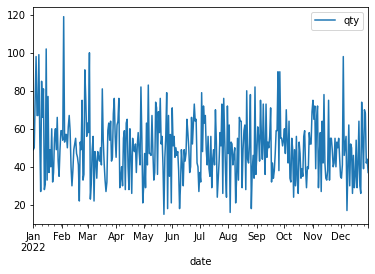

In [164]:
df_fore.plot()
plt.show()

## Trasnform data

In [165]:
#Transform data to log
df_fore = np.log(df_fore)
df_fore.head(3)

,qty
date,
2022-01-01,3.891820
2022-01-02,3.912023
2022-01-03,4.330733


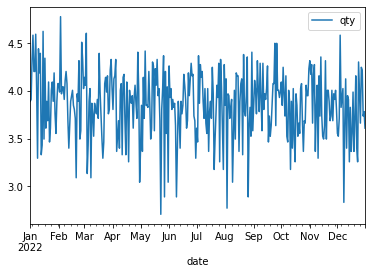

In [166]:
df_fore.plot()
plt.show()

In [43]:
#Split train and test
df_train = df_fore.iloc[:-31]
df_test = df_fore.iloc[-31:]


## Check Data Stationary

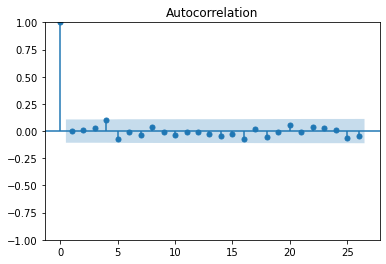

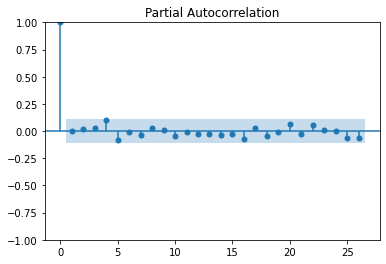

In [44]:
#ACF and PACF plot
acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

In [45]:
#ADF test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 2.4374177848749832e-30


Dari ACF dan PACF plot dan ADF test data sudah statonary dan bisa digunakan untuk ARIMA model.

# Model ARIMA
Pada model arima dibutuhkan parameter (p,d,q) untuk menghasilkan forecast yang akurat. Dilakukan 2 metode untuk mendapatkan parameter ini yaitu dengan auto-fit arima dan manual parameter tuning

## Modelling & Evaluation

In [46]:
#auto-fit ARIMA
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [50]:
#Manual parameter tuning
def tune(z,y,x):
    model = ARIMA(df_train, order=(x,y,z))
    model_fit = model.fit()
    forecast_test = model_fit.forecast(len(df_test))
    df_plot = df_fore[['qty']].iloc[-61:]

    df_plot['forecast'] = [None]*(len(df_plot)-len(forecast_test)) + list(forecast_test)
    
    mae = mean_absolute_error(df_test, forecast_test)
    mape = mean_absolute_percentage_error(df_test, forecast_test)
    rmse = np.sqrt(mean_squared_error(df_test, forecast_test))
    
    return mae,mape,rmse
    
#Parameter combinations
perm = permutations([1,2,3,4],3)
perm = list(perm)

param = []
mae_score = []
mape_score = []
rmse_score = []

for i in perm:
    param.append(str(i))
    mae_score.append(tune(*i)[0])
    mape_score.append(tune(*i)[1])
    rmse_score.append(tune(*i)[2])
    
tuning_df = pd.DataFrame({'param':param,'mae':mae_score,'mape':mape_score,'rsme':rmse_score})
tuning_df.sort_values(by='mae').head(3)

,param,mae,mape,rsme
23,"(4, 3, 2)",0.301966,0.084144,0.377326
20,"(4, 2, 1)",0.302315,0.084484,0.379310
15,"(3, 2, 4)",0.303531,0.084714,0.379237


In [51]:
#Manual parameter tuning
model = ARIMA(df_train, order=(4, 3, 2))
model_fit = model.fit()


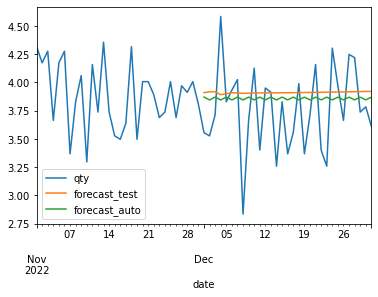

In [52]:
#plot forecasting
forecast_test = model_fit.forecast(len(df_test))
forecast_auto = auto_arima.predict(len(df_test))

df_plot = df_fore[['qty']].iloc[-61:]

df_plot['forecast_test'] = [None]*(len(df_plot)-len(forecast_test)) + list(forecast_test)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(forecast_auto)) + list(forecast_auto)

df_plot.plot()
plt.show()

In [53]:
#Manual parameter tuning metrics

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {round(mae,4)}')
print(f'mape - manual: {round(mape,4)}')
print(f'rmse - manual: {round(rmse,4)}')

mae - manual: 0.3148
mape - manual: 0.0886
rmse - manual: 0.3951


In [54]:
#Auto-fit ARIMA metrics

mae = mean_absolute_error(df_test, forecast_auto)
mape = mean_absolute_percentage_error(df_test, forecast_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_auto))

print(f'mae - auto: {round(mae,4)}')
print(f'mape - auto: {round(mape,4)}')
print(f'rmse - auto: {round(rmse,4)}')

mae - auto: 0.3039
mape - auto: 0.0846
rmse - auto: 0.378


Dari metric di atas kita pilih ARIMA model dengan parameters (2,0,2)

## Forecasting Overall Quantity

In [55]:
#Apply model to forecast data
model = ARIMA(df_fore, order=(2, 0, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

In [56]:
#Re-trasnform data
df_fore = np.exp(df_fore)
forecast = np.exp(forecast)

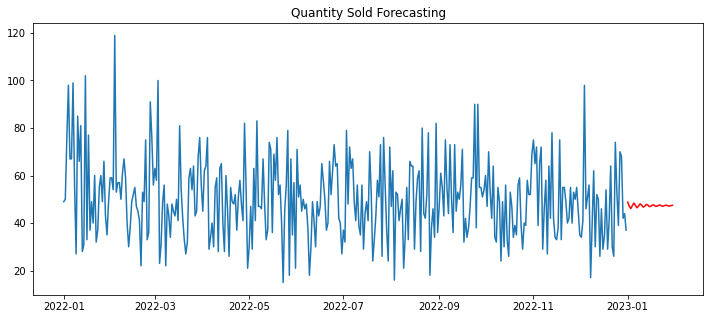

In [57]:
#Plot forecasting
plt.figure(figsize=(12,5))
plt.plot(df_fore)
plt.plot(forecast,color='red')
plt.title('Quantity Sold Forecasting')
plt.show()

In [58]:
forecast.mean()

47.35078195984876

Dari forecasting di atas dapat disimpulkan bahwa untuk quantity penjualan bulan depan adalah sekitar rata-rata  47 pcs per harinya.

## Forecasting Each Product

In [152]:
#Forecast for next 30 days for each product
list_prod = df['product_name'].unique()

dfp = pd.DataFrame({'date':pd.date_range(start='2023-01-01',end='2023-01-30')})
dfp = dfp.set_index('date')
for i in list_prod:
    df_fore = df[['date','product_name','qty']]
    df_fore = df_fore[df_fore['product_name']==i]
    df_fore= df_fore.groupby('date')[['qty']].sum()
    df_fore = df_fore.reset_index()

    df_t = pd.DataFrame({'date':pd.date_range(start='2022-01-01',end='2022-12-31')})
    df_t = df_t.merge(df_fore,how='left',on='date')
    df_t = df_t.fillna(0)
    df_t = df_t.set_index('date')

    model1 = ARIMA(df_t, order=(2, 0, 2))
    model_fit1 = model1.fit()
    forecast1 = model_fit1.forecast(steps=30)
    dfp[i] = forecast1.values
    
dfp.head()

,Crackers,Oat,Thai Tea,Choco Bar,Coffee Candy,Yoghurt,Ginger Candy,Cheese Stick,Cashew,Potato Chip
date,,,,,,,,,,
2023-01-01,5.273700,2.923947,8.203398,6.849279,6.430556,6.428997,8.022471,5.391517,1.707015,3.687155
2023-01-02,4.678443,2.742155,7.133620,7.271720,4.398380,5.480454,8.133445,5.038010,1.733059,3.564448
2023-01-03,4.887939,2.356446,8.057008,6.982935,4.070854,4.437244,8.181126,4.810805,1.716125,3.493547
2023-01-04,4.887109,2.690708,8.006539,6.398008,5.768078,3.939045,8.193707,5.301697,1.722838,3.450442
2023-01-05,4.922644,2.881514,7.583243,6.305524,7.360197,4.290875,8.187017,4.926351,1.717839,3.422330


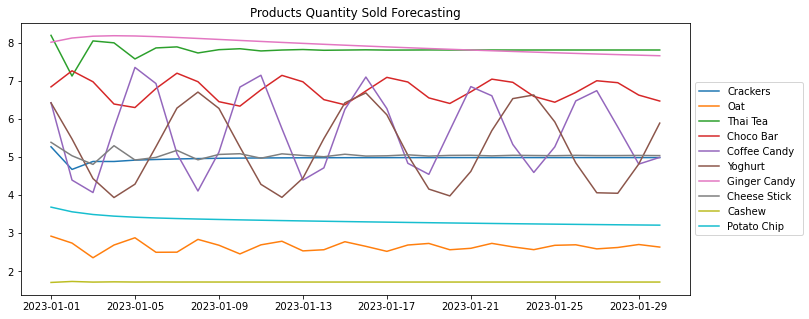

In [153]:
#Plot forecasting
plt.figure(figsize=(12,5))
# plt.plot(df_t)
plt.plot(dfp)
plt.legend(dfp.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Products Quantity Sold Forecasting')
plt.show()

In [161]:
#Products Quantity forecast
round(dfp.describe().T['mean'],0)

Crackers         5.0
Oat              3.0
Thai Tea         8.0
Choco Bar        7.0
Coffee Candy     6.0
Yoghurt          5.0
Ginger Candy     8.0
Cheese Stick     5.0
Cashew           2.0
Potato Chip      3.0
Name: mean, dtype: float64

Dari data forecasting product di atas kita bisa mendapatkan perkiraan rata-rata quantity produk yang terjual tiap harinya.

# Clustering data preparation

In [169]:
df_clust = df.groupby('customerid').agg({'transactionid':'count','qty':'sum','totalamount':'sum'})
df_clust.head(3)

,transactionid,qty,totalamount
customerid,,,
1,17,60,623300
2,13,57,392300
3,15,56,446200


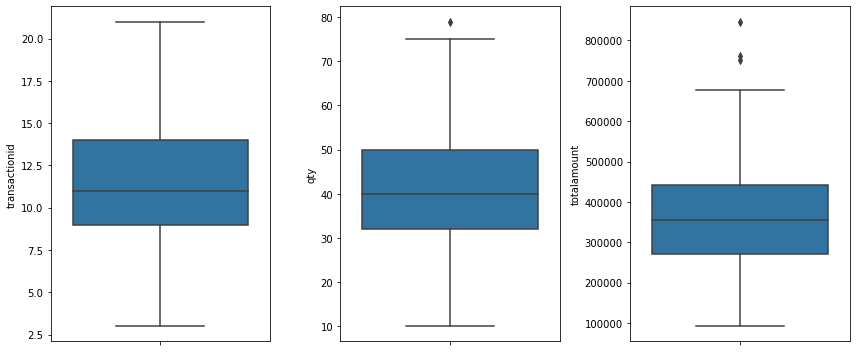

In [61]:
#Check outliers on new dataset
features = df_clust.columns
fig, ax = plt.subplots(1,len(df_clust.columns),figsize=(12,5))
for i in range(0,len(df_clust.columns)):
    sns.boxplot(data=df_clust,y=features[i],ax=ax[i])
plt.tight_layout()
plt.show()

Tidak terdapat outliers yang cukup kritis untuk di handling.

In [62]:
#Standarisasi dataset baru
X = df_clust.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std,columns=df_clust.columns)
df_std.isna().sum()

transactionid    0
qty              0
totalamount      0
dtype: int64

# Model Clustering

## Elbow Method

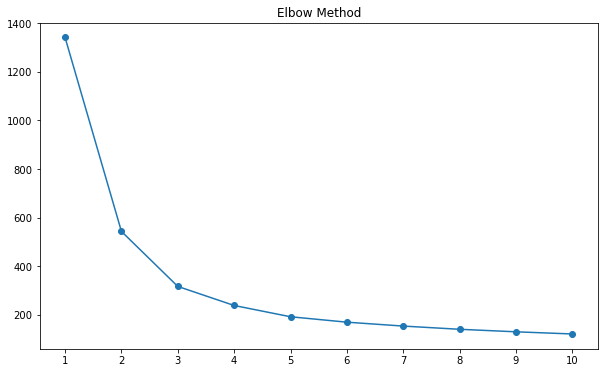

In [63]:
#Elbow method
inertia = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(df_std.values)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.xticks(list(range(1,11)))
plt.plot(range(1,11),inertia,marker='o')
plt.title('Elbow Method')
plt.show()

Pada elbow method menunjukan cluster optimal pada n = 3

In [64]:
# Kmeans n_cluster = 3
#Clustering Kmeans
kmeans_3 = KMeans(n_clusters=3,init='k-means++',max_iter=300,n_init=10,random_state=0)
kmeans_3.fit(X_std)

#Tambah clusters label pada dataset
df_cl3 = pd.DataFrame(data=X_std,columns=df_clust.columns)
df_cl3['cluster'] = kmeans_3.labels_
df_cl3.sample(3)

,transactionid,qty,totalamount,cluster
271,1.779816,1.339571,1.032073,1
398,0.237401,-0.308470,-0.748725,2
193,-1.613497,-1.642598,-1.576872,0


<Figure size 288x288 with 0 Axes>

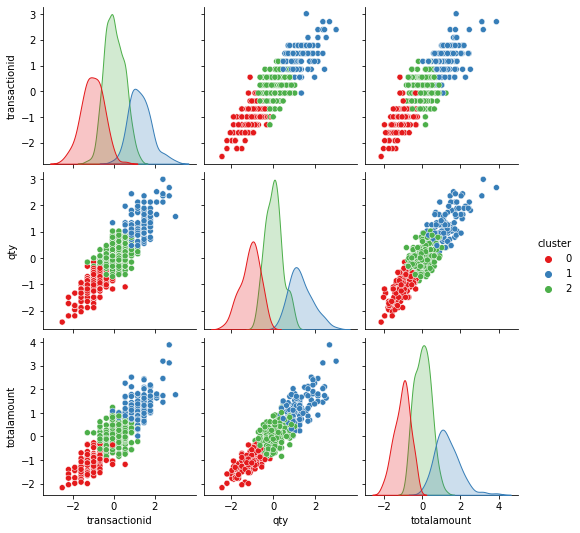

In [174]:
#PLot Before PCA
plt.figure(figsize=(4,4))
sns.pairplot(data=df_cl3,hue='cluster',palette='Set1')
plt.show()

Dari diagram di atas clusters cukup terpisah secara sempurna.

In [66]:
#PCA
pcs_3 = PCA(n_components=2).fit_transform(X_std)
pdf_3 = pd.DataFrame(data=pcs_3,columns=['pc1','pc2'])
pdf_3['cluster'] = df_cl3['cluster']
pdf_3.describe().T

,count,mean,std,min,25%,50%,75%,max
pc1,447.0,3.452371e-17,1.661646,-4.120551,-1.132975,-0.123870,1.081022,5.351262
pc2,447.0,-1.068000e-17,0.386276,-1.279946,-0.242372,-0.003848,0.246496,1.348982
cluster,447.0,1.149888e+00,0.856206,0.000000,0.000000,1.000000,2.000000,2.000000


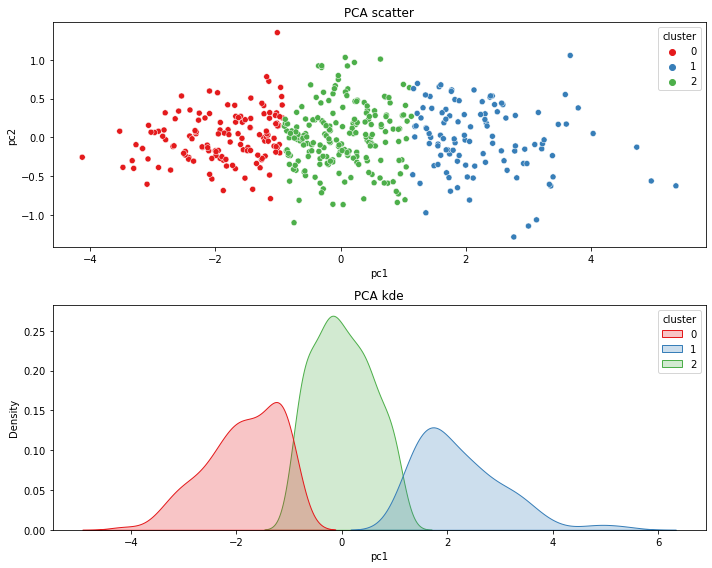

In [108]:
#PCA plot
fig,ax = plt.subplots(2,1,figsize=(10,8))
# plt.figure(figsize=(10,5))
sns.scatterplot(data=pdf_3,x='pc1',y='pc2',hue='cluster',palette='Set1',ax=ax[0])
ax[0].set_title('PCA scatter')
sns.kdeplot(data=pdf_3,x='pc1',hue='cluster',palette='Set1',fill=True,ax=ax[1])
ax[1].set_title('PCA kde')
plt.tight_layout()
plt.show()

## Sillhouette analysis

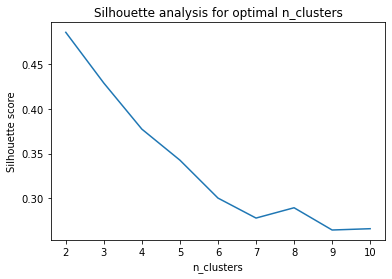

In [69]:
n_clust = list(range(2,11))
silhouette_avg = []
for i in n_clust:
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    
    labels = kmeans.fit_predict(X_std)
    silhouette_avg.append(silhouette_score(X_std,labels))
    
plt.plot(n_clust,silhouette_avg)
plt.xlabel('n_clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis for optimal n_clusters')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.48530485981509097
For n_clusters = 3 The average silhouette_score is : 0.4286478086768933
For n_clusters = 4 The average silhouette_score is : 0.3772419295085858
For n_clusters = 5 The average silhouette_score is : 0.34260947001461384
For n_clusters = 6 The average silhouette_score is : 0.30030062675665914


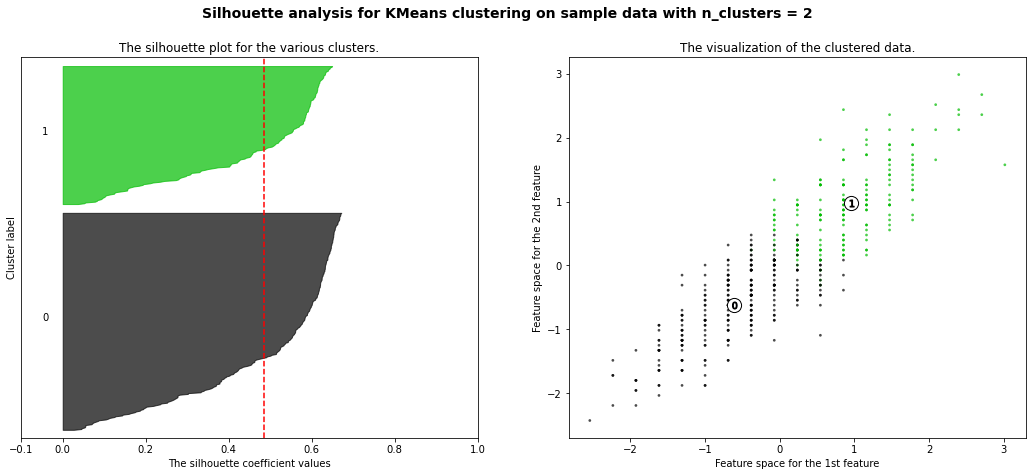

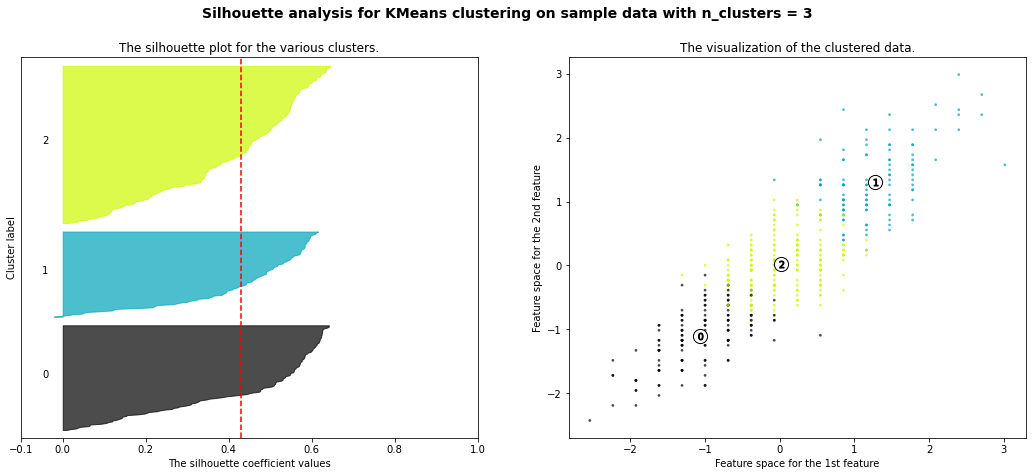

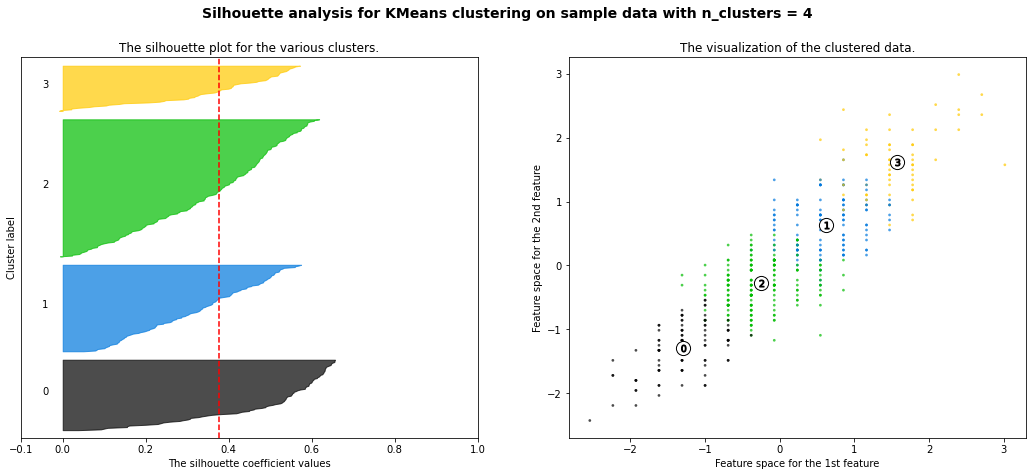

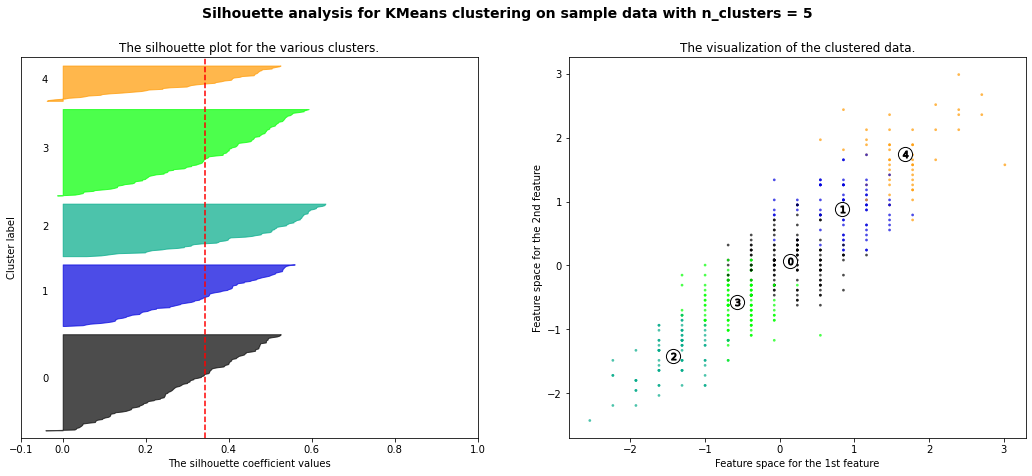

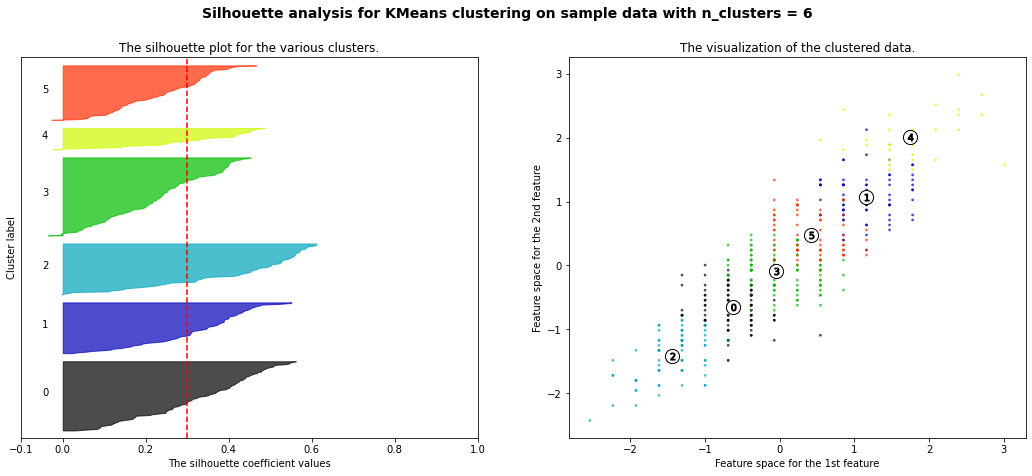

In [70]:
range_n_clusters = [2,3, 4, 5,6]
X = X_std
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++',max_iter=300,n_init=10,random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Dari Silhouette analysis cluster dengan n = 3 terpisah dengan baik dengan silhouette coefficient 0.42.

# Cluster Analysis (RFM Analysis)

In [102]:
df_clust['cluster'] = kmeans_3.labels_

df['recency'] = (pd.to_datetime('2023-01-01') - df_['date']).dt.days.astype('int')
df_r = df.groupby('customerid').agg({'recency':'min'})

df_rfm = df_clust.copy()
df_rfm['recency'] = df_r['recency']

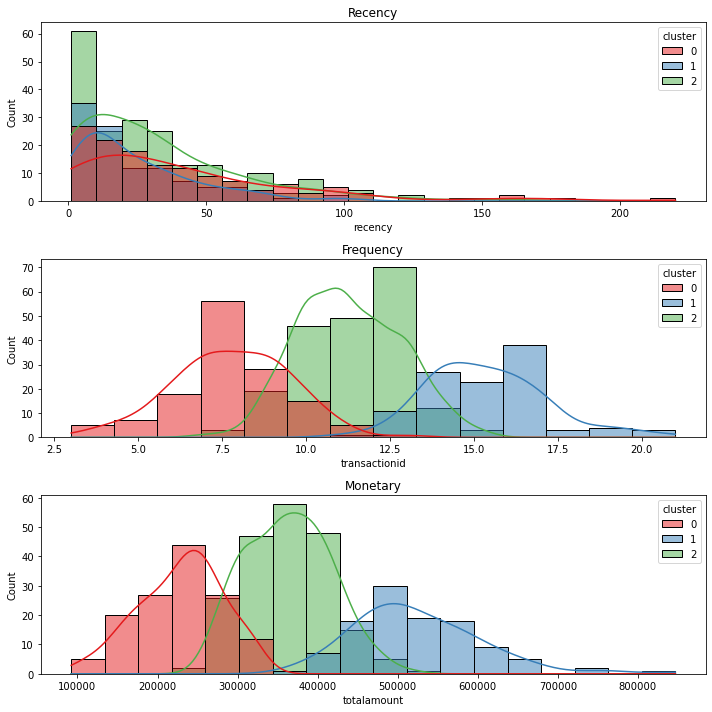

In [105]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
sns.histplot(data=df_rfm,x='recency',hue='cluster',palette='Set1',ax=ax[0],kde=True)
ax[0].set_title('Recency')
sns.histplot(data=df_rfm,x='transactionid',hue='cluster',palette='Set1',ax=ax[1],kde=True)
ax[1].set_title('Frequency')
sns.histplot(data=df_rfm,x='totalamount',hue='cluster',palette='Set1',ax=ax[2],kde=True)
ax[2].set_title('Monetary')

plt.tight_layout()
plt.show()

Customer cluster charcteristic :
- Cluster 0 (New Customer):
    - Mostly having higher recency
    - Have Lowest Frequency and Monetary
    * Strategies :
        - Provide support
        - Gift discount
        - Build Relationship
- Cluster 1 (Potential Loyalist):
    - Have medium recency
    - Have  Highest Frequency and Monetary
    * Strategies :
        - Offer loyalty program
        - Run contest
        - Make them feel special
- Cluster 2 (Loyal Customer):
    - Have Highest low recency
    - Have Medium Frequency and Monetary
    * Strategies :
        - Take feedback and surveys
        - Upsell product
        - Present bonus